In [1]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
from wordcloud import WordCloud
from tqdm import tqdm_notebook as tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

np.random.seed(101)
rand_seed = 101

In [2]:
%%time
ROOT = "./csv"
df = pd.read_csv(
    ROOT + "/propertweets.csv", 
    encoding='utf-8',
    nrows = 10000,
    low_memory=False, 
    parse_dates=False
)
del df['Unnamed: 0']

Wall time: 82.1 ms


## tf-idf: term frequency-inverse document frequency

http://brandonrose.org/clustering

In [3]:
%%time
vectorizer = TfidfVectorizer(
    min_df = 5,
    max_features = 20000,
    analyzer='word', 
    stop_words='english',
    use_idf = True,
    ngram_range = (1, 3)
)

vecz = vectorizer.fit_transform(list(df['tokens']))

print(vecz.shape)


(10000, 11349)
Wall time: 413 ms


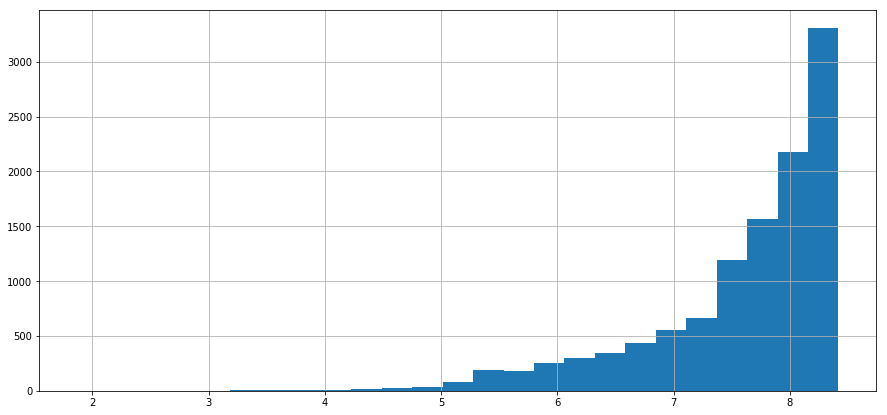

In [4]:
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']
tfidf.tfidf.hist(bins=25, figsize=(15,7))

In [5]:
def plot_word_cloud(terms):
    text = terms.index
    text = ' '.join(list(text))
    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(25, 25))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

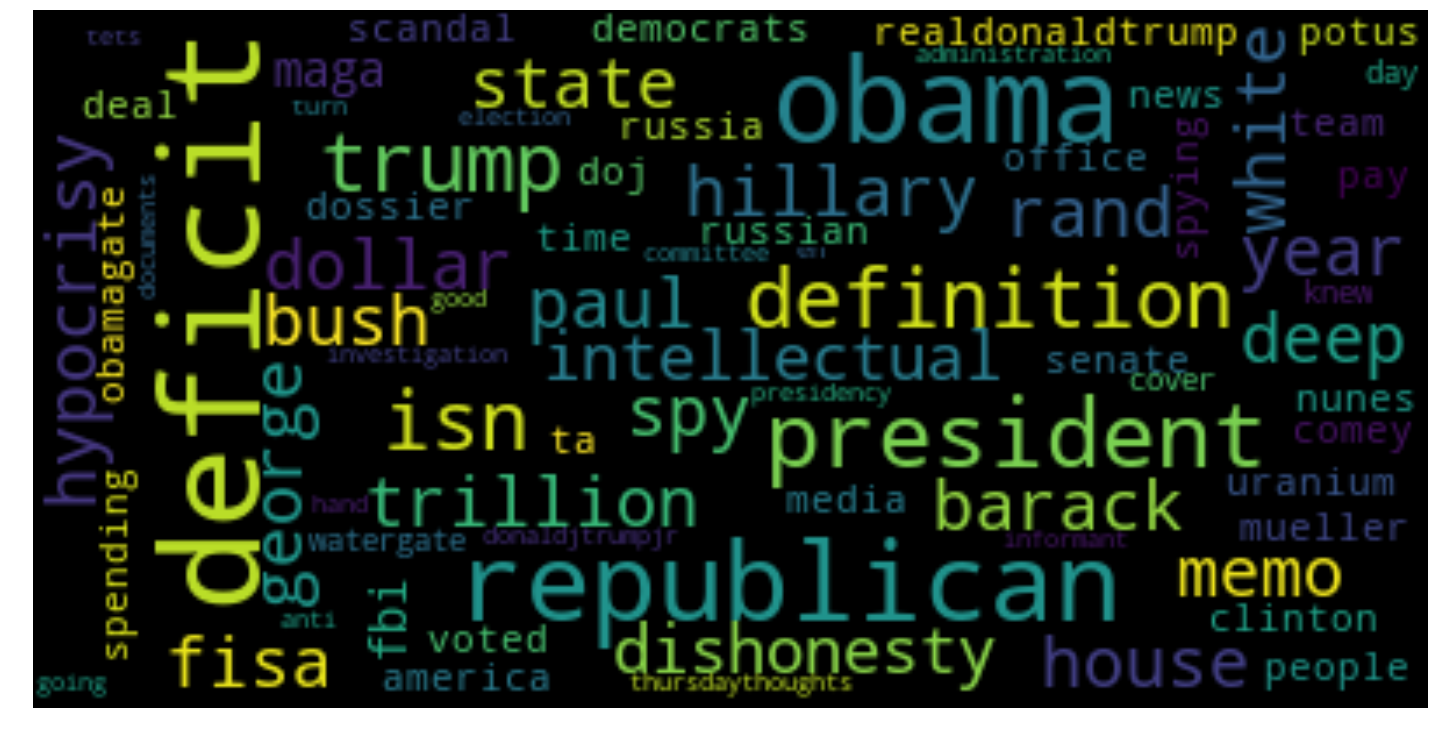

In [6]:
# 30 tokens with lowest tfidf scores (most common)
plot_word_cloud(tfidf.sort_values(by=['tfidf'], ascending=True).head(100))

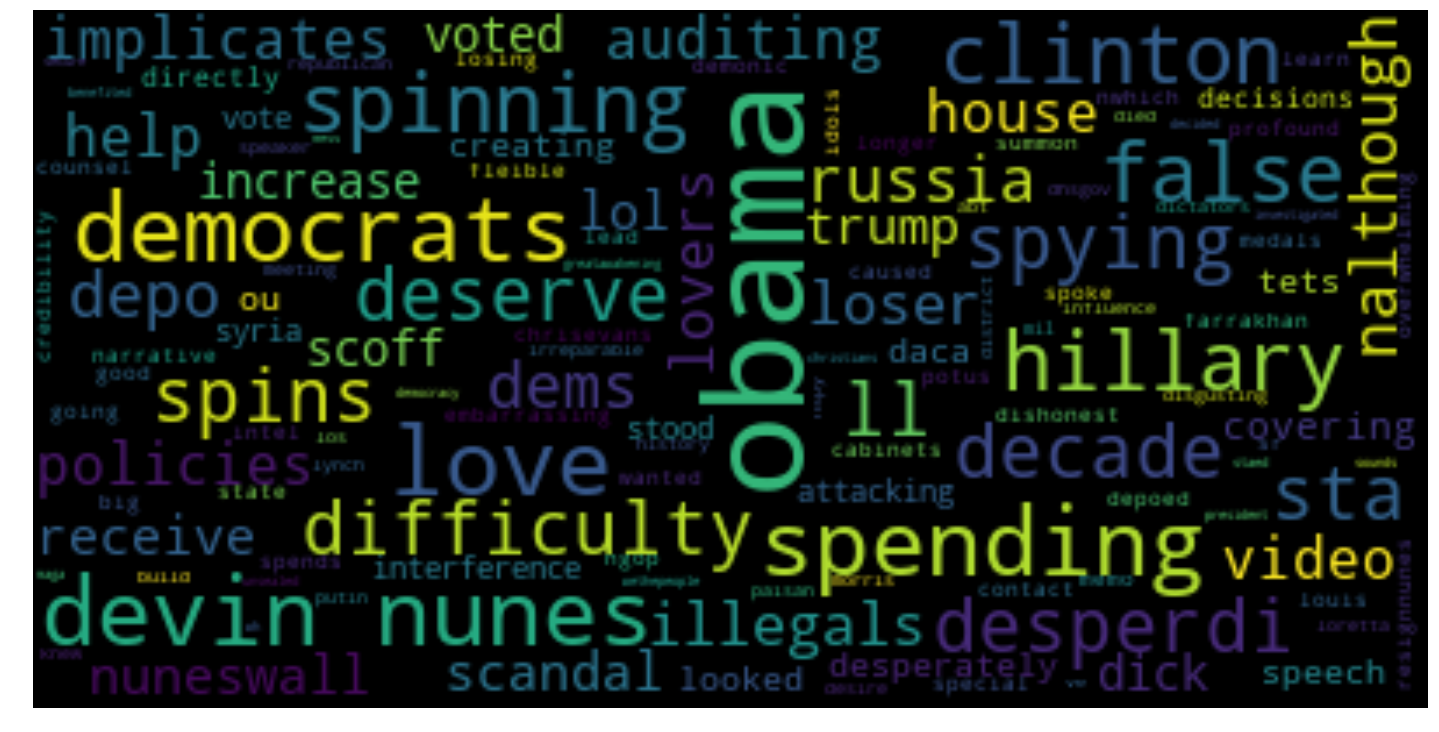

In [7]:
# 30 tokens with highest tfidf scores (least common)
plot_word_cloud(tfidf.sort_values(by=['tfidf'], ascending=False).head(100))

In [8]:
svd = TruncatedSVD(n_components=50, random_state=0)
svd_tfidf = svd.fit_transform(vecz)

svd_tfidf.shape

(10000, 50)

In [9]:
run = False
if run:
# run this (takes times)
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
    tsne_tfidf = tsne_model.fit_transform(svd_tfidf)
    print(tsne_tfidf.shape)
    tsne_tfidf_df = pd.DataFrame(tsne_tfidf)
    tsne_tfidf_df.columns = ['x', 'y']
    tsne_tfidf_df['tokens'] = df['tokens']
    tsne_tfidf_df.to_csv('./csv/tsne_tfidf.csv', encoding='utf-8', index=False)
else:
# or import the dataset directly
    tsne_tfidf_df = pd.read_csv('./csv/tsne_tfidf.csv')

## Kmeans Clustering

In [11]:
distorsions = []
sil_scores = []
k_max = 80
for k in tqdm(range(2, k_max)):
    kmeans_model = MiniBatchKMeans(
        n_clusters=k, 
        init='k-means++', 
        n_init=1, 
        random_state=42,  
        init_size=1000, 
        verbose=True, 
        max_iter=1000
    )
    kmeans_model.fit(vecz)
    sil_score = silhouette_score(vecz, kmeans_model.labels_)
    sil_scores.append(sil_score)
    distorsions.append(kmeans_model.inertia_)

HBox(children=(IntProgress(value=0, max=78), HTML(value='')))

Init 1/1 with method: k-means++
Inertia for init 1/1: 952.918612
Minibatch iteration 1/100000: mean batch inertia: 0.918019, ewa inertia: 0.918019 
Minibatch iteration 2/100000: mean batch inertia: 0.929972, ewa inertia: 0.918258 
Minibatch iteration 3/100000: mean batch inertia: 0.980614, ewa inertia: 0.919505 
Minibatch iteration 4/100000: mean batch inertia: 0.969007, ewa inertia: 0.920495 
Minibatch iteration 5/100000: mean batch inertia: 0.968249, ewa inertia: 0.921450 
Minibatch iteration 6/100000: mean batch inertia: 0.981243, ewa inertia: 0.922645 
Minibatch iteration 7/100000: mean batch inertia: 0.975701, ewa inertia: 0.923706 
Minibatch iteration 8/100000: mean batch inertia: 0.972105, ewa inertia: 0.924674 
Minibatch iteration 9/100000: mean batch inertia: 0.954781, ewa inertia: 0.925276 
Minibatch iteration 10/100000: mean batch inertia: 0.942795, ewa inertia: 0.925627 
Minibatch iteration 11/100000: mean batch inertia: 0.986424, ewa inertia: 0.926843 
Converged (lack of i

Minibatch iteration 6/100000: mean batch inertia: 0.951581, ewa inertia: 0.887466 
Minibatch iteration 7/100000: mean batch inertia: 0.925418, ewa inertia: 0.888225 
Minibatch iteration 8/100000: mean batch inertia: 0.930543, ewa inertia: 0.889071 
Minibatch iteration 9/100000: mean batch inertia: 0.908018, ewa inertia: 0.889450 
Minibatch iteration 10/100000: mean batch inertia: 0.912949, ewa inertia: 0.889920 
Minibatch iteration 11/100000: mean batch inertia: 0.918019, ewa inertia: 0.890482 
Converged (lack of improvement in inertia) at iteration 11/100000
Computing label assignment and total inertia
Init 1/1 with method: k-means++
Inertia for init 1/1: 910.473369
Minibatch iteration 1/100000: mean batch inertia: 0.883188, ewa inertia: 0.883188 
Minibatch iteration 2/100000: mean batch inertia: 0.931628, ewa inertia: 0.884157 
Minibatch iteration 3/100000: mean batch inertia: 0.933188, ewa inertia: 0.885138 
Minibatch iteration 4/100000: mean batch inertia: 0.924125, ewa inertia: 0.

Minibatch iteration 11/100000: mean batch inertia: 0.882468, ewa inertia: 0.806638 
Converged (lack of improvement in inertia) at iteration 11/100000
Computing label assignment and total inertia
Init 1/1 with method: k-means++
Inertia for init 1/1: 847.999420
Minibatch iteration 1/100000: mean batch inertia: 0.769389, ewa inertia: 0.769389 
Minibatch iteration 2/100000: mean batch inertia: 0.876527, ewa inertia: 0.771531 
Minibatch iteration 3/100000: mean batch inertia: 0.876961, ewa inertia: 0.773640 
Minibatch iteration 4/100000: mean batch inertia: 0.893647, ewa inertia: 0.776040 
Minibatch iteration 5/100000: mean batch inertia: 0.867166, ewa inertia: 0.777862 
Minibatch iteration 6/100000: mean batch inertia: 0.911517, ewa inertia: 0.780535 
Minibatch iteration 7/100000: mean batch inertia: 0.864040, ewa inertia: 0.782205 
Minibatch iteration 8/100000: mean batch inertia: 0.844112, ewa inertia: 0.783443 
Minibatch iteration 9/100000: mean batch inertia: 0.862791, ewa inertia: 0.7

Inertia for init 1/1: 791.163199
Minibatch iteration 1/100000: mean batch inertia: 0.789533, ewa inertia: 0.789533 
Minibatch iteration 2/100000: mean batch inertia: 0.817273, ewa inertia: 0.790088 
Minibatch iteration 3/100000: mean batch inertia: 0.827534, ewa inertia: 0.790837 
Minibatch iteration 4/100000: mean batch inertia: 0.847055, ewa inertia: 0.791961 
Minibatch iteration 5/100000: mean batch inertia: 0.834773, ewa inertia: 0.792817 
Minibatch iteration 6/100000: mean batch inertia: 0.803182, ewa inertia: 0.793025 
Minibatch iteration 7/100000: mean batch inertia: 0.815430, ewa inertia: 0.793473 
Minibatch iteration 8/100000: mean batch inertia: 0.756159, ewa inertia: 0.792727 
Minibatch iteration 9/100000: mean batch inertia: 0.839121, ewa inertia: 0.793654 
[MiniBatchKMeans] Reassigning 15 cluster centers.
Minibatch iteration 10/100000: mean batch inertia: 0.831261, ewa inertia: 0.794406 
Minibatch iteration 11/100000: mean batch inertia: 0.854963, ewa inertia: 0.795617 
Co

Minibatch iteration 16/100000: mean batch inertia: 0.874112, ewa inertia: 0.808206 
Minibatch iteration 17/100000: mean batch inertia: 0.855778, ewa inertia: 0.809158 
Minibatch iteration 18/100000: mean batch inertia: 0.864921, ewa inertia: 0.810273 
Converged (lack of improvement in inertia) at iteration 18/100000
Computing label assignment and total inertia
Init 1/1 with method: k-means++
Inertia for init 1/1: 777.842814
Minibatch iteration 1/100000: mean batch inertia: 0.813026, ewa inertia: 0.813026 
Minibatch iteration 2/100000: mean batch inertia: 0.834591, ewa inertia: 0.813457 
Minibatch iteration 3/100000: mean batch inertia: 0.807909, ewa inertia: 0.813346 
Minibatch iteration 4/100000: mean batch inertia: 0.856601, ewa inertia: 0.814211 
Minibatch iteration 5/100000: mean batch inertia: 0.803795, ewa inertia: 0.814003 
Minibatch iteration 6/100000: mean batch inertia: 0.767597, ewa inertia: 0.813075 
Minibatch iteration 7/100000: mean batch inertia: 0.765858, ewa inertia: 0

Minibatch iteration 10/100000: mean batch inertia: 0.804868, ewa inertia: 0.777643 
Minibatch iteration 11/100000: mean batch inertia: 0.883388, ewa inertia: 0.779758 
Minibatch iteration 12/100000: mean batch inertia: 0.801323, ewa inertia: 0.780189 
Minibatch iteration 13/100000: mean batch inertia: 0.845224, ewa inertia: 0.781490 
Minibatch iteration 14/100000: mean batch inertia: 0.853460, ewa inertia: 0.782929 
Minibatch iteration 15/100000: mean batch inertia: 0.783083, ewa inertia: 0.782932 
Minibatch iteration 16/100000: mean batch inertia: 0.856802, ewa inertia: 0.784409 
Minibatch iteration 17/100000: mean batch inertia: 0.836812, ewa inertia: 0.785457 
Converged (lack of improvement in inertia) at iteration 17/100000
Computing label assignment and total inertia
Init 1/1 with method: k-means++
Inertia for init 1/1: 746.017642
Minibatch iteration 1/100000: mean batch inertia: 0.756376, ewa inertia: 0.756376 
Minibatch iteration 2/100000: mean batch inertia: 0.827906, ewa inert

Minibatch iteration 20/100000: mean batch inertia: 0.754825, ewa inertia: 0.772085 
Converged (lack of improvement in inertia) at iteration 20/100000
Computing label assignment and total inertia
Init 1/1 with method: k-means++
Inertia for init 1/1: 717.545278
Minibatch iteration 1/100000: mean batch inertia: 0.764262, ewa inertia: 0.764262 
Minibatch iteration 2/100000: mean batch inertia: 0.780992, ewa inertia: 0.764596 
Minibatch iteration 3/100000: mean batch inertia: 0.767896, ewa inertia: 0.764662 
Minibatch iteration 4/100000: mean batch inertia: 0.779520, ewa inertia: 0.764959 
Minibatch iteration 5/100000: mean batch inertia: 0.757179, ewa inertia: 0.764804 
Minibatch iteration 6/100000: mean batch inertia: 0.716311, ewa inertia: 0.763834 
Minibatch iteration 7/100000: mean batch inertia: 0.716724, ewa inertia: 0.762892 
Minibatch iteration 8/100000: mean batch inertia: 0.772044, ewa inertia: 0.763075 
Minibatch iteration 9/100000: mean batch inertia: 0.715702, ewa inertia: 0.7

Minibatch iteration 18/100000: mean batch inertia: 0.741654, ewa inertia: 0.759622 
Minibatch iteration 19/100000: mean batch inertia: 0.741924, ewa inertia: 0.759268 
Minibatch iteration 20/100000: mean batch inertia: 0.722644, ewa inertia: 0.758536 
Converged (lack of improvement in inertia) at iteration 20/100000
Computing label assignment and total inertia
Init 1/1 with method: k-means++
Inertia for init 1/1: 699.672636
Minibatch iteration 1/100000: mean batch inertia: 0.736056, ewa inertia: 0.736056 
Minibatch iteration 2/100000: mean batch inertia: 0.730902, ewa inertia: 0.735953 
Minibatch iteration 3/100000: mean batch inertia: 0.758897, ewa inertia: 0.736412 
Minibatch iteration 4/100000: mean batch inertia: 0.776144, ewa inertia: 0.737207 
Minibatch iteration 5/100000: mean batch inertia: 0.681326, ewa inertia: 0.736089 
Minibatch iteration 6/100000: mean batch inertia: 0.726349, ewa inertia: 0.735894 
Minibatch iteration 7/100000: mean batch inertia: 0.715414, ewa inertia: 0

Minibatch iteration 3/100000: mean batch inertia: 0.798793, ewa inertia: 0.764213 
Minibatch iteration 4/100000: mean batch inertia: 0.728292, ewa inertia: 0.763495 
Minibatch iteration 5/100000: mean batch inertia: 0.699958, ewa inertia: 0.762224 
Minibatch iteration 6/100000: mean batch inertia: 0.696159, ewa inertia: 0.760903 
Minibatch iteration 7/100000: mean batch inertia: 0.745653, ewa inertia: 0.760598 
Minibatch iteration 8/100000: mean batch inertia: 0.724769, ewa inertia: 0.759881 
Minibatch iteration 9/100000: mean batch inertia: 0.723783, ewa inertia: 0.759159 
[MiniBatchKMeans] Reassigning 36 cluster centers.
Minibatch iteration 10/100000: mean batch inertia: 0.671854, ewa inertia: 0.757414 
Minibatch iteration 11/100000: mean batch inertia: 0.790002, ewa inertia: 0.758065 
Minibatch iteration 12/100000: mean batch inertia: 0.794482, ewa inertia: 0.758793 
Minibatch iteration 13/100000: mean batch inertia: 0.808787, ewa inertia: 0.759793 
Minibatch iteration 14/100000: me

Minibatch iteration 17/100000: mean batch inertia: 0.741448, ewa inertia: 0.755763 
Minibatch iteration 18/100000: mean batch inertia: 0.719683, ewa inertia: 0.755042 
Minibatch iteration 19/100000: mean batch inertia: 0.734449, ewa inertia: 0.754630 
Minibatch iteration 20/100000: mean batch inertia: 0.810373, ewa inertia: 0.755744 
Converged (lack of improvement in inertia) at iteration 20/100000
Computing label assignment and total inertia
Init 1/1 with method: k-means++
Inertia for init 1/1: 702.316522
Minibatch iteration 1/100000: mean batch inertia: 0.741231, ewa inertia: 0.741231 
Minibatch iteration 2/100000: mean batch inertia: 0.710075, ewa inertia: 0.740608 
Minibatch iteration 3/100000: mean batch inertia: 0.754823, ewa inertia: 0.740893 
Minibatch iteration 4/100000: mean batch inertia: 0.706590, ewa inertia: 0.740207 
Minibatch iteration 5/100000: mean batch inertia: 0.617134, ewa inertia: 0.737745 
Minibatch iteration 6/100000: mean batch inertia: 0.719146, ewa inertia: 

Converged (lack of improvement in inertia) at iteration 11/100000
Computing label assignment and total inertia
Init 1/1 with method: k-means++
Inertia for init 1/1: 691.370364
Minibatch iteration 1/100000: mean batch inertia: 0.730250, ewa inertia: 0.730250 
Minibatch iteration 2/100000: mean batch inertia: 0.733090, ewa inertia: 0.730307 
Minibatch iteration 3/100000: mean batch inertia: 0.707004, ewa inertia: 0.729841 
Minibatch iteration 4/100000: mean batch inertia: 0.706579, ewa inertia: 0.729376 
Minibatch iteration 5/100000: mean batch inertia: 0.656998, ewa inertia: 0.727928 
Minibatch iteration 6/100000: mean batch inertia: 0.743526, ewa inertia: 0.728240 
Minibatch iteration 7/100000: mean batch inertia: 0.701311, ewa inertia: 0.727702 
Minibatch iteration 8/100000: mean batch inertia: 0.737404, ewa inertia: 0.727896 
Minibatch iteration 9/100000: mean batch inertia: 0.641481, ewa inertia: 0.726168 
[MiniBatchKMeans] Reassigning 44 cluster centers.
Minibatch iteration 10/1000

Minibatch iteration 2/100000: mean batch inertia: 0.781893, ewa inertia: 0.665012 
Minibatch iteration 3/100000: mean batch inertia: 0.677637, ewa inertia: 0.665265 
Minibatch iteration 4/100000: mean batch inertia: 0.656848, ewa inertia: 0.665096 
Minibatch iteration 5/100000: mean batch inertia: 0.719619, ewa inertia: 0.666187 
Minibatch iteration 6/100000: mean batch inertia: 0.685143, ewa inertia: 0.666566 
Minibatch iteration 7/100000: mean batch inertia: 0.708597, ewa inertia: 0.667406 
Minibatch iteration 8/100000: mean batch inertia: 0.714212, ewa inertia: 0.668342 
Minibatch iteration 9/100000: mean batch inertia: 0.672855, ewa inertia: 0.668432 
[MiniBatchKMeans] Reassigning 49 cluster centers.
Minibatch iteration 10/100000: mean batch inertia: 0.735688, ewa inertia: 0.669777 
Minibatch iteration 11/100000: mean batch inertia: 0.801602, ewa inertia: 0.672414 
Converged (lack of improvement in inertia) at iteration 11/100000
Computing label assignment and total inertia
Init 1/

Converged (lack of improvement in inertia) at iteration 19/100000
Computing label assignment and total inertia
Init 1/1 with method: k-means++
Inertia for init 1/1: 675.486782
Minibatch iteration 1/100000: mean batch inertia: 0.710519, ewa inertia: 0.710519 
Minibatch iteration 2/100000: mean batch inertia: 0.714008, ewa inertia: 0.710589 
Minibatch iteration 3/100000: mean batch inertia: 0.716667, ewa inertia: 0.710710 
Minibatch iteration 4/100000: mean batch inertia: 0.636860, ewa inertia: 0.709233 
Minibatch iteration 5/100000: mean batch inertia: 0.699188, ewa inertia: 0.709033 
Minibatch iteration 6/100000: mean batch inertia: 0.718298, ewa inertia: 0.709218 
Minibatch iteration 7/100000: mean batch inertia: 0.715536, ewa inertia: 0.709344 
Minibatch iteration 8/100000: mean batch inertia: 0.651698, ewa inertia: 0.708191 
Minibatch iteration 9/100000: mean batch inertia: 0.703968, ewa inertia: 0.708107 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 10/1000

Minibatch iteration 11/100000: mean batch inertia: 0.756358, ewa inertia: 0.711418 
Minibatch iteration 12/100000: mean batch inertia: 0.729603, ewa inertia: 0.711782 
Minibatch iteration 13/100000: mean batch inertia: 0.795592, ewa inertia: 0.713458 
Minibatch iteration 14/100000: mean batch inertia: 0.712190, ewa inertia: 0.713432 
Minibatch iteration 15/100000: mean batch inertia: 0.670183, ewa inertia: 0.712567 
Minibatch iteration 16/100000: mean batch inertia: 0.626766, ewa inertia: 0.710851 
Minibatch iteration 17/100000: mean batch inertia: 0.646535, ewa inertia: 0.709565 
Minibatch iteration 18/100000: mean batch inertia: 0.729843, ewa inertia: 0.709971 
Minibatch iteration 19/100000: mean batch inertia: 0.740044, ewa inertia: 0.710572 
Minibatch iteration 20/100000: mean batch inertia: 0.712446, ewa inertia: 0.710610 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 21/100000: mean batch inertia: 0.723478, ewa inertia: 0.710867 
Minibatch iteration 22/100

Minibatch iteration 4/100000: mean batch inertia: 0.650364, ewa inertia: 0.710382 
Minibatch iteration 5/100000: mean batch inertia: 0.676487, ewa inertia: 0.709704 
Minibatch iteration 6/100000: mean batch inertia: 0.671041, ewa inertia: 0.708931 
Minibatch iteration 7/100000: mean batch inertia: 0.726362, ewa inertia: 0.709279 
Minibatch iteration 8/100000: mean batch inertia: 0.620919, ewa inertia: 0.707512 
Minibatch iteration 9/100000: mean batch inertia: 0.696777, ewa inertia: 0.707298 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 10/100000: mean batch inertia: 0.742705, ewa inertia: 0.708006 
Minibatch iteration 11/100000: mean batch inertia: 0.676097, ewa inertia: 0.707367 
Minibatch iteration 12/100000: mean batch inertia: 0.701519, ewa inertia: 0.707251 
Minibatch iteration 13/100000: mean batch inertia: 0.755075, ewa inertia: 0.708207 
Minibatch iteration 14/100000: mean batch inertia: 0.707416, ewa inertia: 0.708191 
Minibatch iteration 15/100000: m

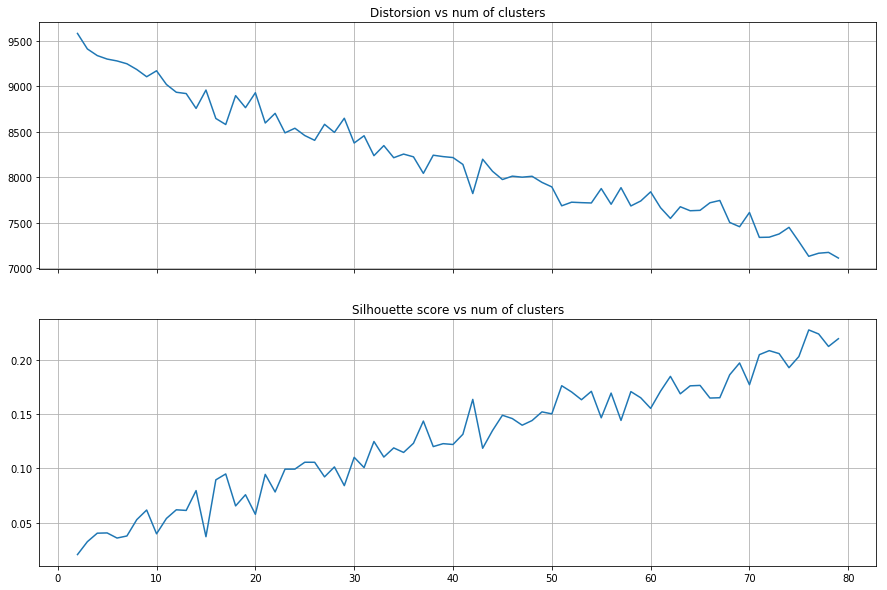

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 10))

ax1.plot(range(2, k_max), distorsions)
ax1.set_title('Distorsion vs num of clusters')
ax1.grid(True)

ax2.plot(range(2, k_max), sil_scores)
ax2.set_title('Silhouette score vs num of clusters')
ax2.grid(True)

In [13]:
num_clusters = 50
kmeans_model = MiniBatchKMeans(
    n_clusters=num_clusters, 
    init='k-means++', 
    n_init=1, 
    random_state=42,                       
    init_size=1000, 
    batch_size=1000, 
    verbose=True, 
    max_iter=1000, 
)
kmeans = kmeans_model.fit(vecz)
kmeans_clusters = kmeans.predict(vecz)
kmeans_distances = kmeans.transform(vecz)

Init 1/1 with method: k-means++
Inertia for init 1/1: 693.684391
Minibatch iteration 1/10000: mean batch inertia: 0.719698, ewa inertia: 0.719698 
Minibatch iteration 2/10000: mean batch inertia: 0.714141, ewa inertia: 0.718587 
Minibatch iteration 3/10000: mean batch inertia: 0.710190, ewa inertia: 0.716908 
Minibatch iteration 4/10000: mean batch inertia: 0.708151, ewa inertia: 0.715156 
Minibatch iteration 5/10000: mean batch inertia: 0.723861, ewa inertia: 0.716897 
Minibatch iteration 6/10000: mean batch inertia: 0.716222, ewa inertia: 0.716762 
Minibatch iteration 7/10000: mean batch inertia: 0.697135, ewa inertia: 0.712837 
Minibatch iteration 8/10000: mean batch inertia: 0.718796, ewa inertia: 0.714029 
Minibatch iteration 9/10000: mean batch inertia: 0.690509, ewa inertia: 0.709325 
[MiniBatchKMeans] Reassigning 35 cluster centers.
Minibatch iteration 10/10000: mean batch inertia: 0.703099, ewa inertia: 0.708080 
Minibatch iteration 11/10000: mean batch inertia: 0.779666, ewa 

In [20]:
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
all_keywords = []
for i in range(num_clusters):
    topic_keywords = []
    for j in sorted_centroids[i, :10]:
        topic_keywords.append(terms[j])
    all_keywords.append(topic_keywords)

keywords_df = pd.DataFrame(index=['topic_{0}'.format(i) for i in range(num_clusters)], 
                           columns=['keyword_{0}'.format(i) for i in range(10)],
                           data=all_keywords)
keywords_df.head(50)

,keyword_0,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9
topic_0,nif,land,seek,pray,face,folks,called,hear,winning,watch
topic_1,fbi doj special,stonewalling requests,deep state cover,mode fbi doj,mode fbi,requests comey documents,comey documents,stonewalling requests comey,doj special counsel,requests comey
topic_2,michaelslinden rand paul,head eplodes,eplodes,michaelslinden rand,trillion ta cuaaaaaarrgggghghghghghghhghhghhg,cuaaaaaarrgggghghghghghghhghhghhg head eplodes,cuaaaaaarrgggghghghghghghhghhghhg head,cuaaaaaarrgggghghghghghghhghhghhg,ta cuaaaaaarrgggghghghghghghhghhghhg head,ta cuaaaaaarrgggghghghghghghhghhghhg
topic_3,deficits,republican deficits isn,deficits isn,deficits isn definition,isn definition hypocrisy,definition hypocrisy,hypocrisy,senate spending president,spending president,spending president obama
topic_4,acting,coup,ag,obama hrc,deputy,director comey,yates,hrc,fbi director,mccabe
topic_5,economy kick,kick,economy,time,trump economy kick,economy kick drop,economy kick march,time trump economy,points today time,time obama elected
topic_6,tas,doors,nall,doubled,offensive,americafirst maga,voters,rights,dem,citizens
topic_7,backed,backed terrorists,terrorists,iranian,hocking,years ago,billion,traced,repo,released
topic_8,strzok investigated,hillary strzok investigated,jackposobiec doj official,jackposobiec doj,strzok investigated flynn,doj official interviewed,interviewed hillary,interviewed hillary strzok,investigated flynn suddenly,suddenly resigns
topic_9,president trump,president,realdonaldtrump time sta,referring president,recognized president trump,recognized president,longer recognized,time sta referring,time sta,highest office longer


In [23]:
svd = TruncatedSVD(n_components=2, random_state=0)
svd_kmeans = svd.fit_transform(vecz)
run = True
if run:
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
    tsne_kmeans = tsne_model.fit_transform(svd_kmeans)
    kmeans_df = pd.DataFrame(tsne_kmeans, columns=['x', 'y'])
    kmeans_df['cluster'] = kmeans_clusters
    kmeans_df['cluster'] = kmeans_df['cluster'].map(str)
    kmeans_df.to_csv('./csv/tsne_kmeans.csv', index=False, encoding='utf-8')
else:
    kmeans_df = pd.read_csv('./csv/tsne_kmeans.csv')
    kmeans_df['cluster'] = kmeans_df['cluster'].map(str)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.005s...
[t-SNE] Computed neighbors for 10000 samples in 0.132s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.711807
[t-SNE] Error after 500 iterations: 0.685870


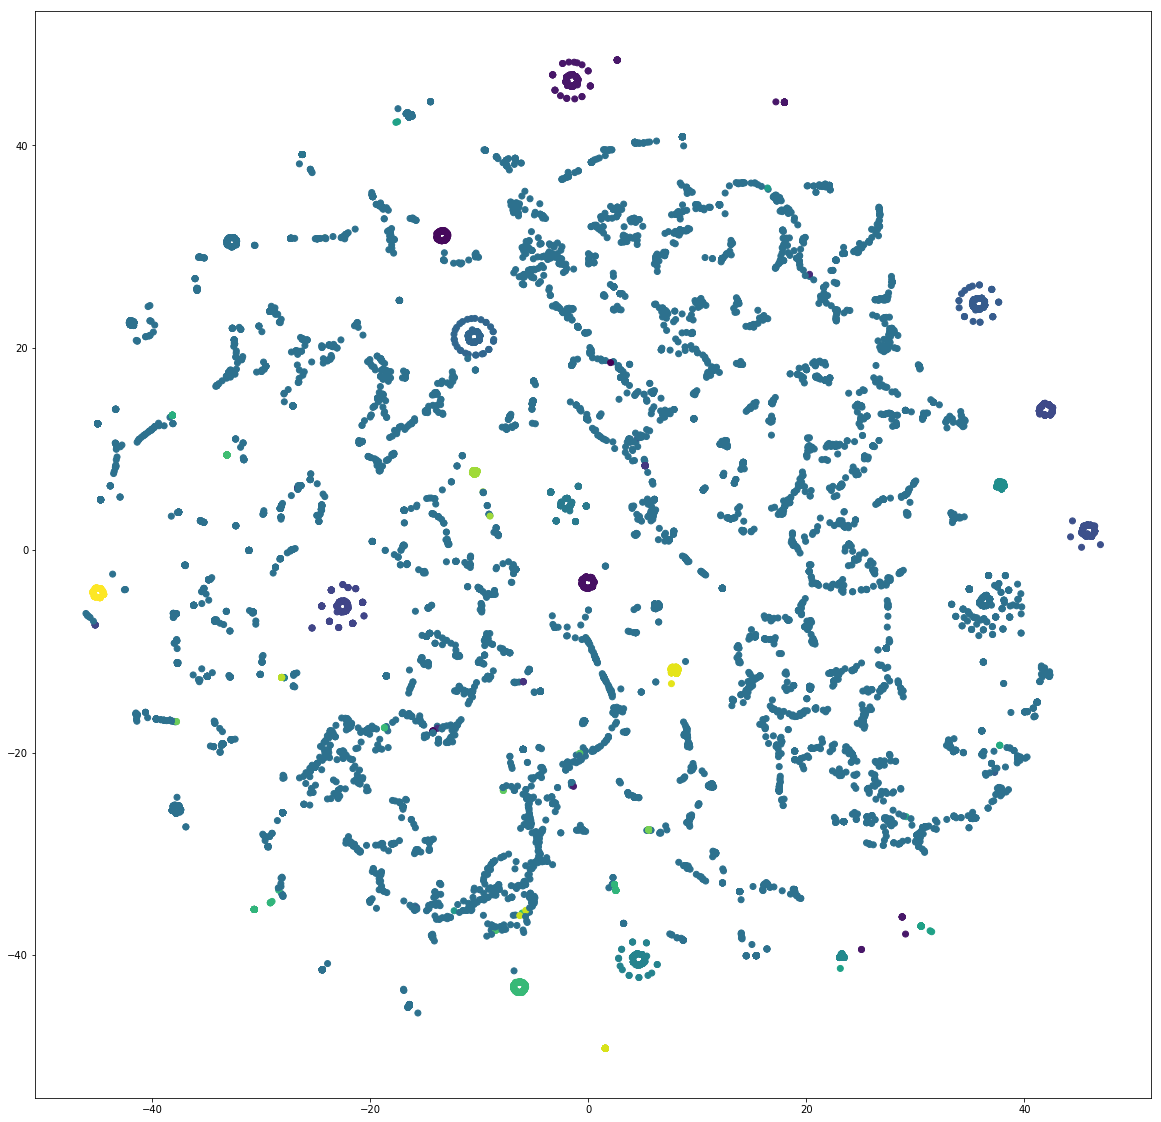

In [24]:
plt.figure(figsize=(20,20))
plt.scatter(x = kmeans_df.x, y = kmeans_df.y, c = kmeans_df.cluster)
plt.show()


In [25]:
kmeans_df.head()

,x,y,cluster
0,-37.732113,-24.405325,18
1,17.472651,-15.854892,18
2,-10.362659,28.973253,18
3,27.329462,-9.686125,18
4,-37.930943,-25.154202,18
